# Inicialización del entorno

In [1]:
# Se importan las librerías necesarias para poder capturar los datos,
# generar el dataset y hacer un primer análisis exploratorio
from requests import get
from bs4 import BeautifulSoup
from datetime import date, timedelta
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Se define la URL de donde se van a obtener los datos
url = 'https://www.worldometers.info/coronavirus/'
# Se guarda la fecha de ayer en una variable
timestamp = date.today() - timedelta(days=1)
# Se define el nombre del fichero donde se guardará el dataset
dataset_file_name = 'covid-19_world_2020.csv'
# Se define una variable para activar el guardado del dataset en un csv
save_csv = True
# Se define otra variable para concatenar datos en el csv
append_csv = True
# Se define el percentil de casos sobre el que han de estar los países
# para mostrarlos en el análisis exploratorio
percentile = 97
# Se define el número días a mostrar de en el análisis exploratorio
window = 15
# Se definen las características de las representaciones gráficas
# https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot
# https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
# https://stackoverflow.com/questions/25328003/how-can-i-change-the-font-size-using-seaborn-facetgrid
sns.set(rc={'figure.figsize':(10,6)}, font_scale=1.2)

# Implementación de las técnicas de _web scrapping_

In [3]:
# Se obtiene el contenido de la web
page = get(url).content
# Se convierte el contenido en un objeto tipo BeautifulSoup
soup = BeautifulSoup(page)

In [4]:
# Se genera un diccionario vacío donde se almacenarán los datos
_dict = {}
# Se navega por el objeto tipo BeautifulSoup en busca de todos los tags 'div'.
# Para cada uno de los tags 'div'
for _div in soup.find_all('div'):
    # Para cada  uno de los atributos del tag 'div'
    for _attr in _div.attrs:
        # Si el nombre del atributo es 'id'
        if _attr == 'id':
            # Si el valor del atributo 'id' es 'nav-yesterday'.
            # De esta manera se obtienen los datos de ayer,
            # asegurando que los datos están lo más actualizados posible
            # para el día en cuestión
            if _div['id'] == 'nav-yesterday':
                # Para cada uno de los tags tr (fila) 
                # de dentro del tag tbody (tabla)
                for _tr in _div.tbody.find_all('tr'):
                    for i, _td in enumerate(_tr.find_all('td')):  
                        # Siempre que el rediduo de dividir
                        # el indide entre 12 sea 0, porque 
                        # la tabla tiene 12 atributos,
                        # Se recupera el primer atributo 
                        # que corresponde al país
                        if i%12 == 0:
                            _a = _td.find('a')
                            # En el caso de que el nombre del país sea 
                            # de los que se muestra como un enlace
                            if _a:
                                # Se obtiene el nombre del país
                                country_name = _a['href'].split('/')[1]
                            # En el caso contrario
                            else:
                                _span = _td.find('span')
                                # Si es de los que se muestran en dos filas
                                if _span:
                                    # Se obtiene el nombre del país
                                    country_name = _span.contents[0]
                                # En caso contrario, siempre que
                                # contenga datos
                                elif len(_td.contents) > 0:
                                     # Se obtiene el nombre del país
                                    country_name = _td.contents[0]
                            # En caso de haber obtenido el nombre del país
                            if country_name:
                                # Se eliminan espacios innecesarios
                                country_name = country_name.strip()
                                # Si los datos del país no han sido 
                                # añadidos aún al diccionario
                                if country_name not in list(_dict.keys()):
                                    # Se añade al diccionario una entrada 
                                    # para el país
                                    _dict[country_name] = {} 
                                # Para ese país, se añade la fecha del dato
                                _dict[country_name][timestamp] = []                            
                        # Para el resto de atributos,
                        # que corresponden a los datos de cada país
                        else:
                            # Si contiene datos
                            if len(_td.contents) > 0:
                                # Se limpia el dato de cualquier símbolo 
                                # para poder convertirlo en un valor numérico
                                data = _td.contents[0].replace(
                                    '+', '').replace(',', '').strip()
                                # Si el dato contiene un valor
                                if data and data != 'N/A':
                                    # Se almacena como número en el diccionario
                                    _dict[country_name][timestamp].append(
                                        float(data))
                                # En caso contrario
                                else:
                                    # Se almacena un 0 en el diccionario
                                    _dict[country_name][timestamp].append(0)
                            # En caso contrario
                            else:
                                # Se almacena un 0 en el diccionario
                                _dict[country_name][timestamp].append(0)          

# Generación y almacenamiento del _dataset_ a partir de los datos obtenidos

In [5]:
# Se genera un DataFrame a partir del diccionario que contiene los datos
# https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
df = pd.concat({k: pd.DataFrame(v).T for k, v in _dict.items()}, axis = 0)
df.columns = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 
              'total_recovered', 'active_cases', 'servious_critical', 
              'total_cases_1M_pop', 'total_deaths_1M_pop', 'total_tests', 
              'tests_1M_pop']
df.index.names = ['country', 'date']

# Se elimina las filas que no aportan información o con datos globales
df = df.drop(['World', ''])
df = df.dropna()

# Se muestra la estructura del DataFrame resultante
display(df.head())

,,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop,total_deaths_1M_pop,total_tests,tests_1M_pop
country,date,,,,,,,,,,,
afghanistan,2020-04-12,607.0,52.0,18.0,0.0,32.0,557.0,0.0,16.0,0.50,0.0,0.0
albania,2020-04-12,446.0,13.0,23.0,0.0,217.0,206.0,7.0,155.0,8.00,3877.0,1347.0
algeria,2020-04-12,1914.0,89.0,293.0,18.0,591.0,1030.0,60.0,44.0,7.00,3359.0,77.0
andorra,2020-04-12,638.0,37.0,29.0,3.0,128.0,481.0,17.0,8257.0,375.00,1673.0,21653.0
angola,2020-04-12,19.0,0.0,2.0,0.0,4.0,13.0,0.0,0.6,0.06,0.0,0.0


In [6]:
# Si está activado el guardado del dataset en un fichero
if save_csv:
    # Si está activada la opción de concatenar datos
    if append_csv:
        print('Adding data to csv...')
        # Se concatenan los datos del dataset en el fichero
        df.to_csv(dataset_file_name, mode = 'a', 
                  header = False, index = True) 
    # En caso contrario
    else:
        print('Creating csv...')
        # Se genera un nuevo fichero
        df.to_csv(dataset_file_name, index = True)    

# Validación del _dataset_ y primer análisis exploratiro

In [7]:
# Se comprueba que los datos se han almacenado correctamente en el fichero
# Generando un DataFrame a partir del fichero
df = pd.read_csv(dataset_file_name)

In [8]:
# Se convierte en tipo fecha la columna 'date'
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Se obtienen los datos de la última muestra para cada país
df = df.sort_values(by = ['date', 'active_cases'], ascending = False)
last_date = list(df['date'])[0]
df_last_date = df[(df['date'] == last_date)]

# Se analizan solo los países con más casos
df_last_date = df_last_date[(df_last_date['active_cases'] > 
                     np.percentile(df['active_cases'], 
                                   percentile))]

display(df_last_date.head())

,country,date,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop,total_deaths_1M_pop,total_tests,tests_1M_pop
4101,us,2020-04-12,560300.0,27421.0,22105.0,1528.0,32634.0,505561.0,11766.0,1693.0,67.0,2832258.0,8557.0
3998,italy,2020-04-12,156363.0,4092.0,19899.0,431.0,34211.0,102253.0,3343.0,2586.0,329.0,1010193.0,16708.0
3969,france,2020-04-12,132591.0,2937.0,14393.0,561.0,27186.0,91012.0,6845.0,2031.0,221.0,333807.0,5114.0
4078,spain,2020-04-12,166831.0,3804.0,17209.0,603.0,62391.0,87231.0,7371.0,3568.0,368.0,355000.0,7593.0
4097,uk,2020-04-12,84279.0,5288.0,10612.0,737.0,0.0,73323.0,1559.0,1241.0,156.0,352974.0,5200.0


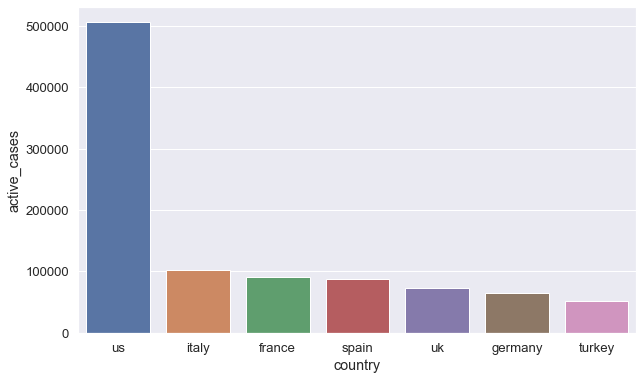

In [9]:
# Se representan gráficamente la última muestra
# del número total de casos para cada país
plot = sns.barplot(x = "country", y = "active_cases", data = df_last_date)

In [10]:
# Se usan solamente los datos de los países más activos
# https://stackoverflow.com/questions/12096252/use-a-list-of-values-to-select-rows-from-a-pandas-dataframe
df_evolution = df[df['country'].isin(list(df_last_date['country']))]

# Se ordenan los casos más significativos por fecha
df_evolution = df_evolution.sort_values(by = 'date',
                              ascending = True)

# Se usan solamente los datos de los últimos días
df_evolution = df_evolution[df_evolution['date'] > 
                            last_date - timedelta(days=window)]

# Se convierten las fechas a tipo string 
# para visualizarlas mejor en los gráficos
df_evolution['date'] = df_evolution['date'].dt.strftime('%Y-%m-%d')

display(df_evolution.head())

,country,date,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop,total_deaths_1M_pop,total_tests,tests_1M_pop
1191,spain,2020-03-29,80110.0,6875.0,6803.0,821.0,14709.0,58598.0,4165.0,1713.0,146.0,0.0,0.0
1196,us,2020-03-29,142460.0,18882.0,2484.0,264.0,4559.0,135417.0,2970.0,430.0,8.0,0.0,0.0
1183,italy,2020-03-29,97689.0,5217.0,10779.0,756.0,13030.0,73880.0,3906.0,1616.0,178.0,0.0,0.0
1175,germany,2020-03-29,62435.0,4740.0,541.0,108.0,9211.0,52683.0,1979.0,745.0,6.0,0.0,0.0
1195,uk,2020-03-29,19522.0,2433.0,1228.0,209.0,135.0,18159.0,163.0,288.0,18.0,0.0,0.0


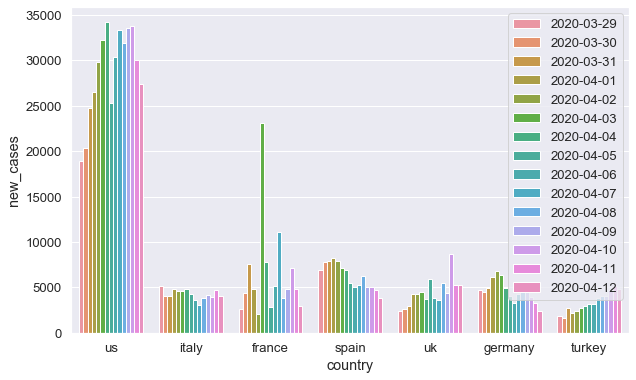

In [11]:
# Se representa gráficamente la evolución temporal de los nuevos
# casos confirmados para cada día y país
plot = sns.barplot(x = "country", y = "new_cases", hue = "date",
                   order = list(df_last_date['country']),
                   data = df_evolution).legend(loc = 'upper right')

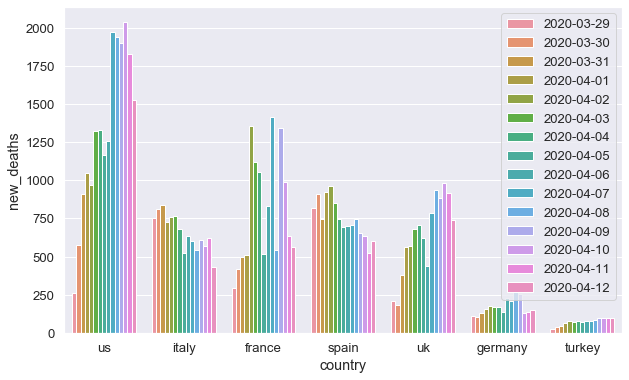

In [12]:
# Se representa gráficamente la evolución temporal de las nuevas
# defunciones confirmadas para cada día y país
plot = sns.barplot(x = "country", y = "new_deaths", hue = "date",
                   order = list(df_last_date['country']),
                   data = df_evolution).legend(loc = 'upper right')

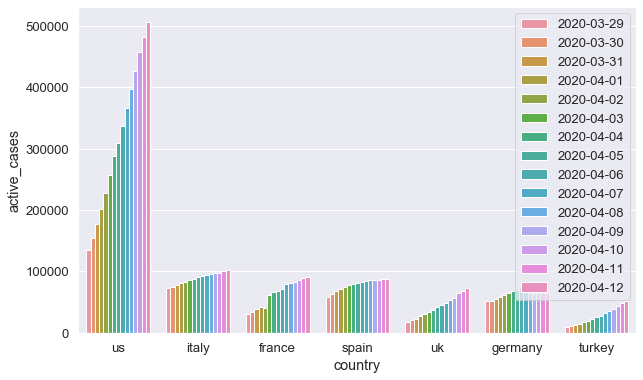

In [13]:
# Se representa gráficamente la evolución temporal del total de
# casos activos confirmados para cada día y país
plot = sns.barplot(x = "country", y = "active_cases", hue = "date",
                   order = list(df_last_date['country']),
                   data = df_evolution).legend(loc = 'upper right')